In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import anndata as ad
import scipy.io
import matplotlib.pyplot as plt
import os
import sys
import STitch3D
import warnings
warnings.filterwarnings("ignore")

/home/xzhang/yes/envs/STitch3D/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


加载数据

In [2]:
mat = scipy.io.mmread("/home/xzhang/workplace/STitch3D-main/data/DLPFC/GSE144136_GeneBarcodeMatrix_Annotated.mtx")
meta = pd.read_csv("/home/xzhang/workplace/STitch3D-main/data/DLPFC/GSE144136_CellNames.csv", index_col=0)
meta.index = meta.x.values
group = [i.split('.')[1].split('_')[0] for i in list(meta.x.values)]
condition = [i.split('.')[1].split('_')[1] for i in list(meta.x.values)]
celltype = [i.split('.')[0] for i in list(meta.x.values)]
meta["group"] = group
meta["condition"] = condition
meta["celltype"] = celltype
genename = pd.read_csv("/home/xzhang/workplace/STitch3D-main/data/DLPFC/GSE144136_GeneNames.csv", index_col=0)
genename.index = genename.x.values
adata_ref = ad.AnnData(X=mat.tocsr().T)
adata_ref.obs = meta
adata_ref.var = genename
adata_ref = adata_ref[adata_ref.obs.condition.values.astype(str)=="Control", :]

In [3]:
#spatial data
anno_df = pd.read_csv('/home/xzhang/workplace/STitch3D-main/data/DLPFC/barcode_level_layer_map.tsv', sep='\t', header=None)

slice_idx = [151670, 151671, 151672, 151673, 151674, 151675, 151676]

adata_st1 = sc.read_visium(path="/home/xzhang/workplace/STitch3D-main/data/spatialLIBD/%d" % slice_idx[0],
                          count_file="%d_filtered_feature_bc_matrix.h5" % slice_idx[0])
anno_df1 = anno_df.iloc[anno_df[1].values.astype(str) == str(slice_idx[0])]
anno_df1.columns = ["barcode", "slice_id", "layer"]
anno_df1.index = anno_df1['barcode']
adata_st1.obs = adata_st1.obs.join(anno_df1, how="left")
adata_st1 = adata_st1[adata_st1.obs['layer'].notna()]

adata_st2 = sc.read_visium(path="/home/xzhang/workplace/STitch3D-main/data/spatialLIBD/%d" % slice_idx[1],
                          count_file="%d_filtered_feature_bc_matrix.h5" % slice_idx[1])
anno_df2 = anno_df.iloc[anno_df[1].values.astype(str) == str(slice_idx[1])]
anno_df2.columns = ["barcode", "slice_id", "layer"]
anno_df2.index = anno_df2['barcode']
adata_st2.obs = adata_st2.obs.join(anno_df2, how="left")
adata_st2 = adata_st2[adata_st2.obs['layer'].notna()]

adata_st3 = sc.read_visium(path="/home/xzhang/workplace/STitch3D-main/data/spatialLIBD/%d" % slice_idx[2],
                          count_file="%d_filtered_feature_bc_matrix.h5" % slice_idx[2])
anno_df3 = anno_df.iloc[anno_df[1].values.astype(str) == str(slice_idx[2])]
anno_df3.columns = ["barcode", "slice_id", "layer"]
anno_df3.index = anno_df3['barcode']
adata_st3.obs = adata_st3.obs.join(anno_df3, how="left")
adata_st3 = adata_st3[adata_st3.obs['layer'].notna()]

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


组织切片对齐

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


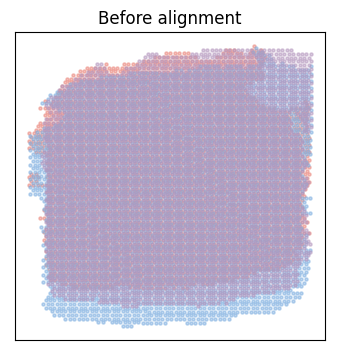

Using PASTE algorithm for alignemnt.
Aligning spots...


RESULT MIGHT BE INACURATE
Max number of iteration reached, currently 100000. Sometimes iterations go on in cycle even though the solution has been reached, to check if it's the case here have a look at the minimal reduced cost. If it is very close to machine precision, you might actually have the correct solution, if not try setting the maximum number of iterations a bit higher
RESULT MIGHT BE INACURATE
Max number of iteration reached, currently 100000. Sometimes iterations go on in cycle even though the solution has been reached, to check if it's the case here have a look at the minimal reduced cost. If it is very close to machine precision, you might actually have the correct solution, if not try setting the maximum number of iterations a bit higher
RESULT MIGHT BE INACURATE
Max number of iteration reached, currently 100000. Sometimes iterations go on in cycle even though the solution has been reached, to check if it's the case here have a look at the minimal reduced cost. If it is v

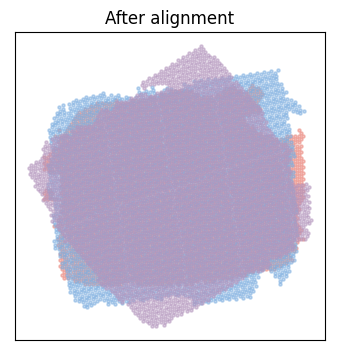

In [4]:
adata_st_list_raw = [adata_st1, adata_st2, adata_st3]
for i, adata in enumerate(adata_st_list_raw):
 
    duplicates = adata.var.index[adata.var.index.duplicated()]
    unique_genes = ~adata.var.index.duplicated()
    adata_st_list_raw[i] = adata[:, unique_genes].copy()

adata_st_list = STitch3D.utils.align_spots(adata_st_list_raw, plot=True)




构建3D空间图

In [5]:
adata_st, adata_basis = STitch3D.utils.preprocess(adata_st_list,
                                                  adata_ref,
                                                  
                                                  sample_col="group",
                                                  slice_dist_micron=[10., 300.],
                                                  n_hvg_group=500)

Finding highly variable genes...


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
... storing 'group' as categorical
... storing 'condition' as categorical
... storing 'celltype' as categorical


6798 highly variable genes selected.
Calculate basis for deconvolution...


Trying to set attribute `.obs` of view, copying.


1 batches are used for computing the basis vector of cell type <Astros_1>.
17 batches are used for computing the basis vector of cell type <Astros_2>.
14 batches are used for computing the basis vector of cell type <Astros_3>.
17 batches are used for computing the basis vector of cell type <Endo>.
17 batches are used for computing the basis vector of cell type <Ex_10_L2_4>.
15 batches are used for computing the basis vector of cell type <Ex_1_L5_6>.
15 batches are used for computing the basis vector of cell type <Ex_2_L5>.
17 batches are used for computing the basis vector of cell type <Ex_3_L4_5>.
14 batches are used for computing the basis vector of cell type <Ex_4_L_6>.
17 batches are used for computing the basis vector of cell type <Ex_5_L5>.
16 batches are used for computing the basis vector of cell type <Ex_6_L4_6>.
16 batches are used for computing the basis vector of cell type <Ex_7_L4_6>.
15 batches are used for computing the basis vector of cell type <Ex_8_L5_6>.
13 batches a